# 1. Build your own neural network with 3 hidden layers using pytorch (60 points)

In [27]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from torchvision import transforms as T
from glob import glob
# from tqdm import tqdm
from PIL import Image
import numpy as np
from PIL import Image
import pandas as pd
import os

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Train your model using cow teat datasets (30 points)

## You can resize the image to 75 * 75 *3

In [22]:
Img_size = 75  
num_epochs = 10
learning_rate = 0.001
batch_size = 30
pin_memory = True
num_workers = 2

transforms = T.Compose([T.ToTensor(), T.Resize([Img_size, Img_size]), T.GaussianBlur(3)])

class Testdata(Dataset):
    def __init__(self, directory, transforms):
        self.files = glob(directory)
        self.transform = transforms
        self.dir = directory
    def __len__(self):
        return len(self.files)
    def __getitem__(self, index):
        file = self.files[index]
        img = Image.open(file).convert('RGB')
        img = self.transform(img)
        return img, file

full_dataset = ImageFolder(r"SCTL-main/SCTL-main/Train", transform = transforms)
test_ds = Testdata("SCTL-main/SCTL-main/Test/Test/*.jpg", transforms=transforms)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_dl = DataLoader(train_dataset, batch_size=batch_size, pin_memory=pin_memory)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=pin_memory)
test_dl = DataLoader(test_ds, batch_size=batch_size, pin_memory=pin_memory)

In [5]:
class TeatClassifier(nn.Module): 
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(3*75*75, 10000), 
            nn.ReLU(),
            nn.Linear(10000, 5000),
            nn.ReLU(),
            nn.Linear(5000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 4)
        )

    def forward(self, x): 
        return self.model(x)

device = "cuda" if torch.cuda.is_available() else "cpu"

clf = TeatClassifier().to(device)

In [6]:
opt = torch.optim.Adam(clf.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss() 
training_loss = []
valid_loss = []
valid_acc = []
train_acc = []


for epoch in range(num_epochs):
# Training loop
    correct = 0
    for batch in train_dl: 
        X,y = batch 
        X, y = X.to(device), y.to(device) 
        yhat = clf(X) 
        loss = criterion(yhat, y) 
        # Apply backprop 
        opt.zero_grad()
        loss.backward() 
        opt.step() 
        correct += (torch.argmax(yhat, dim=1) == y).float().sum().detach().cpu()
    accuracy = 100 * correct / len(train_dataset)
    train_acc.append(accuracy)    
    print(f"Epoch:{epoch} training loss is {accuracy}")
    training_loss.append(loss.item())
    print(f"Epoch:{epoch} training loss is {loss.item()}")
    
    clf.eval()

# Valid loop
    correct = 0
    for batch in valid_dl:
        X, y = batch 
        X, y = X.to(device), y.to(device) 
        yhat = clf(X) 
        loss = criterion(yhat, y)
        correct += (torch.argmax(yhat, dim=1) == y).float().sum().detach().cpu()
    accuracy = 100 * correct / len(valid_dataset)
    valid_acc.append(accuracy)
    print(f"Epoch:{epoch} valid accuracy is {accuracy}") 
    print(f"Epoch:{epoch} valid loss is {loss.item()}")
    valid_loss.append(loss.item())


Epoch:0 training loss is 39.825897216796875
Epoch:0 training loss is 1.0769389867782593
Epoch:0 valid accuracy is 56.08695602416992
Epoch:0 valid loss is 1.0135738849639893
Epoch:1 training loss is 42.328617095947266
Epoch:1 training loss is 1.074897289276123
Epoch:1 valid accuracy is 60.869564056396484
Epoch:1 valid loss is 1.0205308198928833
Epoch:2 training loss is 46.78998947143555
Epoch:2 training loss is 1.108281135559082
Epoch:2 valid accuracy is 48.69565200805664
Epoch:2 valid loss is 1.0937522649765015
Epoch:3 training loss is 48.857452392578125
Epoch:3 training loss is 1.0415321588516235
Epoch:3 valid accuracy is 58.260868072509766
Epoch:3 valid loss is 1.077430009841919
Epoch:4 training loss is 52.44831466674805
Epoch:4 training loss is 1.056543231010437
Epoch:4 valid accuracy is 55.21739196777344
Epoch:4 valid loss is 1.0407706499099731
Epoch:5 training loss is 54.29814910888672
Epoch:5 training loss is 0.9895236492156982
Epoch:5 valid accuracy is 64.34782409667969
Epoch:5 

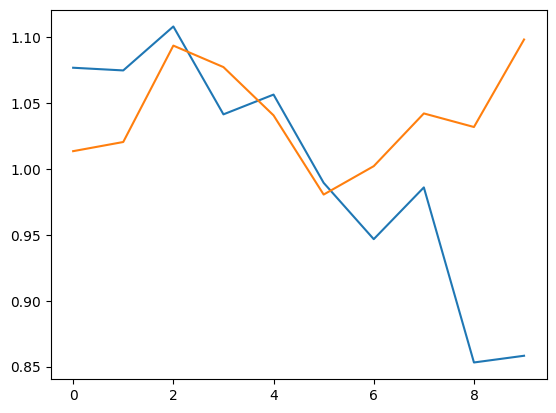

In [7]:
plt.plot(training_loss)
plt.plot(valid_loss)

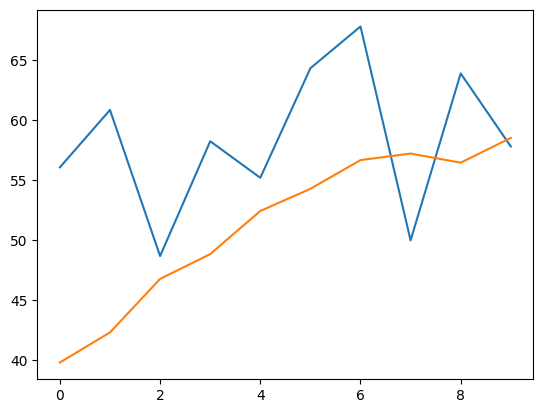

In [8]:
plt.plot(valid_acc)
plt.plot(train_acc)

In [26]:
with open('model_state.pt', 'wb') as f: 
    torch.save(clf.state_dict(), f) 

with open('model_state.pt', 'rb') as f: 
    clf.load_state_dict(torch.load(f))
      
test_preds = []
files = []

for batch in test_dl:
    img, fname = batch
    pred = clf(img.to(device))
    test_preds.extend(torch.argmax(pred, dim=1).detach().cpu())
    files.extend(np.array(fname).flatten())

print(len(files))
print(len(test_preds))
df = pd.DataFrame({"Imagename":files, "preds":test_preds})
df.preds = df.preds.astype(int)
df.Imagename = df.Imagename.apply(lambda x: x.split("/")[-1][5:])
df.to_csv("submission.csv", header=None, index=None)
pd.read_csv("submission.csv")

380
380


,20200724_093921_RF_C2_PP_M.jpg,0
0,20200724_093926_LH_C1_PN_M.jpg,0
1,20200724_093930_LF_C1_PN_M.jpg,0
2,20200724_093930_LH_C3_PN_M.jpg,0
3,20200724_093935_RF_C2_PP_M.jpg,0
4,20200724_093940_LH_C1_PP_M.jpg,0
...,...,...
374,R9_0787_50_crop_LF_C2_PN_m.jpg,0
375,R9_0791_55_crop_LF_C3_PN_m.jpg,1
376,R9_0791_55_crop_LH_C2_PN_m.jpg,0
377,R9_0791_55_crop_RH_C2_PN_m.jpg,1


# 3. Evaluate your model using the developed software (10 points)

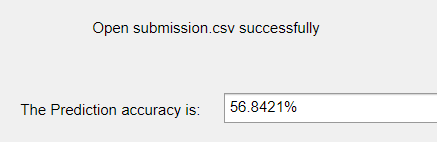